## Подключение библиотек

In [ ]:
# Подключение библиотек
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import os
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import matplotlib.pyplot as plt



## Считывание файлов с новостями

In [ ]:
true_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/pythonProject/itog/true_all.csv')
false_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/pythonProject/itog/fake_all.csv')
df = pd.concat([true_df, false_df], ignore_index=True)

df.head()

df.sample(n=5)

,text,label
9825,Гюльчехра Бобокулова станет новой наставницей ...,Ложь
9659,Чиновник 15 лет не являлся в суд по делу о кор...,Ложь
1115,Певица Лолита Милявская высмеяла видео телевед...,Правда
3447,Одиноких людей можно выявить по постам в соцсе...,Правда
3664,Северная Македония получила от Италии на безмо...,Правда


## Предобработка данных


### 1) Приведение текстов к нижнему регистру

In [ ]:
df["text"] = df["text"].str.lower().str.strip().str.rstrip('.').str.replace('«', '"').str.replace('»', '"').str.rstrip(',')
df.shape

(10200, 2)

### 2) Удаление дубликов

In [ ]:
df = df.drop_duplicates(subset=['text'])
df.head()

,text,label
0,ученые университета тафтса и гарвардского унив...,Правда
1,олимпийского чемпиона по фигурному катанию дми...,Правда
2,главной ошибкой при лечении коронавируса являе...,Правда
3,российская туристка отдохнула в шарм-эш-шейхе ...,Правда
4,"президент владимир путин назвал причину, по ко...",Правда


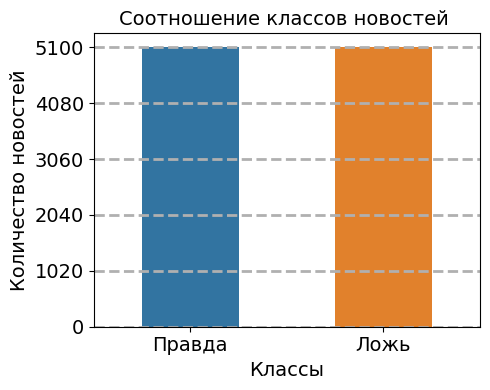

In [ ]:
values = df["label"].value_counts()
values_df = values.reset_index()
values_df.columns = ['Метки', 'Количество']


plt.figure(figsize=(5, 4))

palette = sns.color_palette(n_colors=len(values_df))

ax = sns.barplot(
    x='Метки',
    y='Количество',
    data=values_df,
    palette=palette,
    hue='Метки',
    legend=False,
    width=0.5
)

ax.yaxis.grid(True, linestyle='--', linewidth=2)

max_count = values_df['Количество'].max()
num_ticks = 6
tick_step = max(1, int(np.ceil(max_count / (num_ticks - 1))))
y_ticks = np.arange(0, max_count + tick_step, tick_step)
ax.set_yticks(y_ticks)

ax.set_title('Соотношение классов новостей ', fontsize=14)
ax.set_xlabel('Классы', fontsize=14)
ax.set_ylabel('Количество новостей', fontsize=14)
ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()

### 3) Удаление стоп-слов

In [ ]:
# Удаление стоп слов
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

def preprocess(text):
    text = re.sub(r'<.*?>', '', text)
    text = text.lower()
    tokens = [w for w in text.split() if w not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].astype(str).apply(preprocess)



df["label"] = df["label"].apply(lambda x: 0 if x == "Ложь" else 1)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Разделение выборки на обучающую и тестовую

In [ ]:
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:

# 4. Токенизация и подготовка датасета
tokenizer = BertTokenizerFast.from_pretrained('DeepPavlov/rubert-base-cased')
MAX_LEN = 128

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = NewsDataset(
    train_df['clean_text'].tolist(),
    train_df['label'].tolist(),
    tokenizer,
    MAX_LEN
)
eval_dataset = NewsDataset(
    eval_df['clean_text'].tolist(),
    eval_df['label'].tolist(),
    tokenizer,
    MAX_LEN
)

# 5. Загрузка модели и настройка обучения
model = BertForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased',
    num_labels=2
)

# Настройка параметров обучения
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary'
    )
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

# Инициализация обучающего класса модели
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


# 6. Обучение модели
trainer.train()







# 7. Сохранение лучшей модели
best_model_path = os.path.join(training_args.output_dir, 'best_model')
model.save_pretrained(best_model_path)
tokenizer.save_pretrained(best_model_path)





Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: turilkin-valera (turilkin-valera-bmstu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.132800,0.044194,0.989706,0.991296,0.988428,0.989860
2,0.021600,0.089182,0.985784,0.973684,0.999036,0.986197
3,0.002000,0.052741,0.993137,0.994203,0.992285,0.993243


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.132800,0.044194,0.989706,0.991296,0.988428,0.989860
2,0.021600,0.089182,0.985784,0.973684,0.999036,0.986197
3,0.002000,0.052741,0.993137,0.994203,0.992285,0.993243


('./results/best_model/tokenizer_config.json',
 './results/best_model/special_tokens_map.json',
 './results/best_model/vocab.txt',
 './results/best_model/added_tokens.json',
 './results/best_model/tokenizer.json')

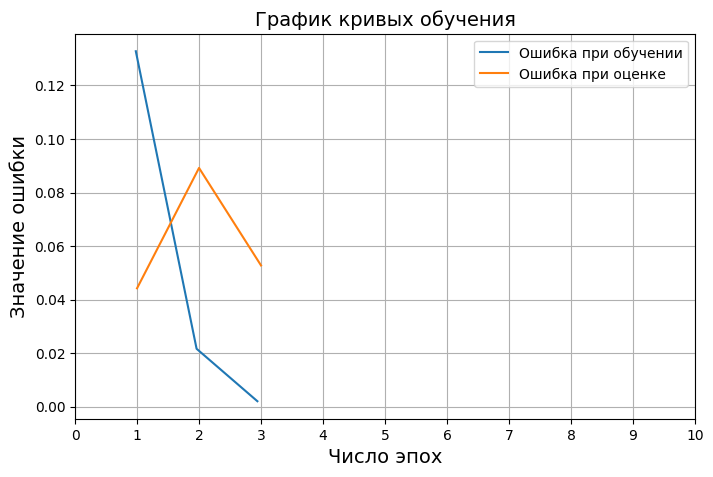

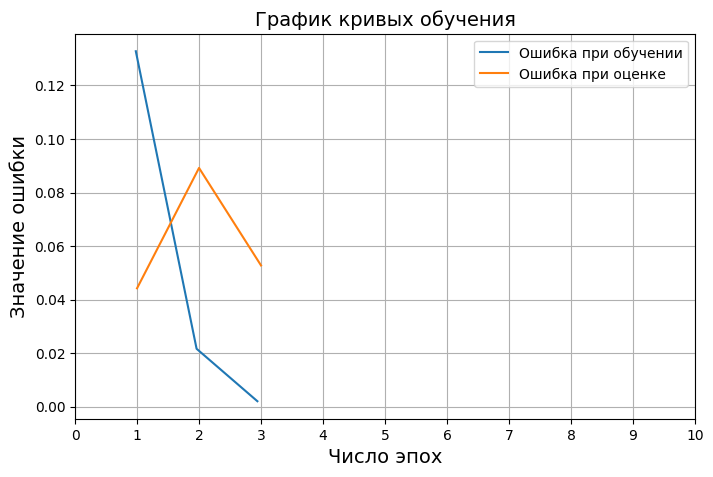

In [ ]:
log_history = trainer.state.log_history
df_log = pd.DataFrame(log_history)

plt.figure(figsize=(8, 5))
plt.plot(df_log[df_log['loss'].notna()]['epoch'], df_log[df_log['loss'].notna()]['loss'], label='Ошибка при обучении')
if 'eval_loss' in df_log.columns:
    plt.plot(df_log[df_log['eval_loss'].notna()]['epoch'], df_log[df_log['eval_loss'].notna()]['eval_loss'], label='Ошибка при оценке')
plt.xlabel('Число эпох', fontsize=14)
plt.ylabel('Значение ошибки', fontsize=14)
plt.title('График кривых обучения', fontsize=14)
plt.xticks(np.arange(0, 11 ,1))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
predictions = trainer.predict(eval_dataset)
metrics = compute_metrics(predictions)


📊 Метрики классификации:
Accuracy: 0.9931
Precision: 0.9942
Recall: 0.9923
F1: 0.9932

📄 Подробный отчёт:
              precision    recall  f1-score   support

        Ложь       0.99      0.99      0.99      1003
      Правда       0.99      0.99      0.99      1037

    accuracy                           0.99      2040
   macro avg       0.99      0.99      0.99      2040
weighted avg       0.99      0.99      0.99      2040



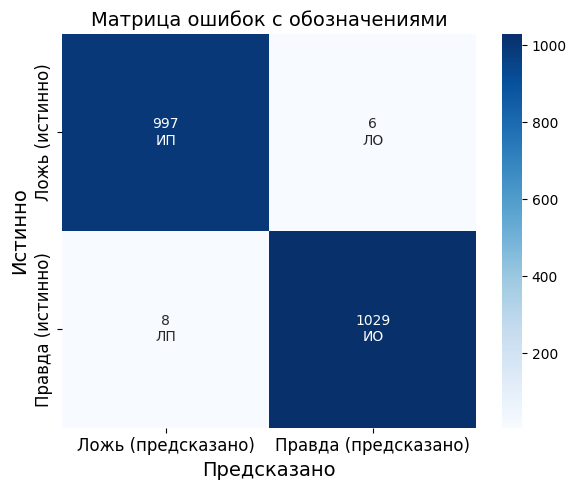

In [ ]:
print("\n📊 Метрики классификации:")
for metric_name, value in metrics.items():
    print(f"{metric_name.capitalize()}: {value:.4f}")

print("\n📄 Подробный отчёт:")
print(classification_report(
    predictions.label_ids,
    np.argmax(predictions.predictions, axis=1),
    target_names=["Ложь", "Правда"]
))

cm = confusion_matrix(predictions.label_ids, np.argmax(predictions.predictions, axis=1))
labels = np.array([["ИП", "ЛО"],
                   ["ЛП", "ИО"]])
annot = np.empty_like(cm).astype(str)

for i in range(2):
    for j in range(2):
        annot[i, j] = f"{cm[i, j]}\n{labels[i, j]}"

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
            xticklabels=["Ложь (предсказано)", "Правда (предсказано)"],
            yticklabels=["Ложь (истинно)", "Правда (истинно)"])

plt.xlabel('Предсказано', fontsize=14)
plt.ylabel('Истинно', fontsize=14)
plt.title('Матрица ошибок с обозначениями', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# 8. Функция для классификации одной новости
def classify_news(text: str) -> str:
    clean = preprocess(text)
    inputs = tokenizer(
        clean,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=MAX_LEN
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    pred_id = torch.argmax(outputs.logits, dim=1).item()
    return 'Ложная' if pred_id == 0 else 'Правдивая'

In [ ]:
sample = 'РИА Новости. Коты атаковали Белгородскую область'
print(f"Текст новости: {sample}\nРаспознана как: {classify_news(sample)}")

Текст новости: РИА Новости. Коты атаковали Белгородскую область
Распознана как: Ложная
